Code for **"Inpainting"** figures $6$, $8$ and 7 (top) from the main paper. 

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from PIL import Image, ImageEnhance
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import r2_score

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

import earthpy
import earthpy.plot as ep
import earthpy.spatial as es

from utils.inpainting_utils import *
from skimage import exposure
import numpy.ma as ma

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

In [2]:
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# Choose figure

In [3]:
## Fig 6
# img_path  = 'data/inpainting/vase.png'
# mask_path = 'data/inpainting/vase_mask.png'

## Fig 8
# img_path  = 'data/inpainting/library.png'
# mask_path = 'data/inpainting/library_mask.png'

## Fig 7 (top)
#img_path  = 'data/inpainting/kate.png'
#mask_path = 'data/inpainting/kate_mask.png'

# Another text inpainting example
# img_path  = 'data/inpainting/peppers.png'
# mask_path = 'data/inpainting/peppers_mask.png'

#THIS!!!bands of space image
# img_tif = Image.open('./fields_1-4_bands.tif')
# img_path_4 = np.asarray(img_tif)[:,:,3]
# img_path_3 = np.asarray(img_tif)[:,:,2]
# img_path_2 = np.asarray(img_tif)[:,:,1]
# img_path_1 = np.asarray(img_tif)[:,:,0]

# #THIS!!!landsat_mask
# mask_tif = Image.open('./gap_mask')
# mask_path = np.array(mask_tif)

#AREA2!!!bands of space image
# img_tif = Image.open('/home/apetrovskaya/Inpainting/area2/b3_32.tif')#('./fields_1-4_bands.tif')
# img_path = np.array(img_tif)#[:,:,0]

#AREA2!!!landsat_mask
# mask_tif = Image.open('/home/apetrovskaya/Inpainting/area2/gap_mask.tif')
# mask_path = np.array(mask_tif)

#FULL_MASK
# mask_tif = Image.open('./gap_mask_full.TIF')
# mask_path = np.array(mask_tif)

#png satellite image
# img_tif = gdal.Open('./fields_1-4_bands_png.png')
# img_path = np.array(img_tif.ReadAsArray())

#soil tomography
img_tif = Image.open('./test_dip_patch1.tif')
img_path1 = np.array(img_tif)

img_tif = Image.open('./test_dip_patch3.tif')
img_path2 = np.array(img_tif)

# #inrcrease contrast
# norm = (img_path.astype(np.float)-img_path.min())*255.0 / (img_path.max()-img_path.min())
# im_pil=Image.fromarray(norm.astype(np.uint8))

# contrast = ImageEnhance.Contrast(im_pil)
# contrast = contrast.enhance(3) # set FACTOR > 1 to enhance contrast, < 1 to decrease
# im_ar = np.array(contrast.getdata())
# img_path = im_ar.reshape(img_path.shape)


NET_TYPE = 'skip_depth4' # one of skip_depth4|skip_depth2|UNET|ResNet

In [3]:
def _stretch_im(arr, str_clip=2):
    """Stretch an image in numpy ndarray format using a specified clip value.
    Parameters
    ----------
    arr: numpy array
        N-dimensional array in rasterio band order (bands, rows, columns)
    str_clip: int
        The % of clip to apply to the stretch. Default = 2 (2 and 98)
    Returns
    ----------
    arr: numpy array with values stretched to the specified clip %
    """
    s_min = str_clip
    s_max = 100 - str_clip
    arr_rescaled = np.zeros_like(arr)
    for ii, band in enumerate(arr):
        lower, upper = np.percentile(band, (s_min, s_max))
        arr_rescaled[ii] = exposure.rescale_intensity(
            band, in_range=(lower, upper)
        )
    return arr_rescaled.copy()

def func(rgb_bands):
    if ma.is_masked(rgb_bands):
        # Build alpha channel
        mask = ~(ma.getmask(rgb_bands[0])) * 255

        # Add the mask to the array & swap the axes order from (bands,
        # rows, columns) to (rows, columns, bands) for plotting
        rgb_bands = np.vstack(
            (es.bytescale(rgb_bands), np.expand_dims(mask, axis=0))
        ).transpose([1, 2, 0])
    else:
        # Index bands for plotting and clean up data for matplotlib
        rgb_bands = es.bytescale(rgb_bands).transpose([1, 2, 0])
    return rgb_bands

In [4]:
img_path=np.dstack((img_path_1,img_path_2,img_path_3, img_path_4)).transpose([2, 0, 1])
img_path_im=img_path

In [5]:
img_path_im=_stretch_im(img_path_im, 1)
img_path_im = func(img_path_im)

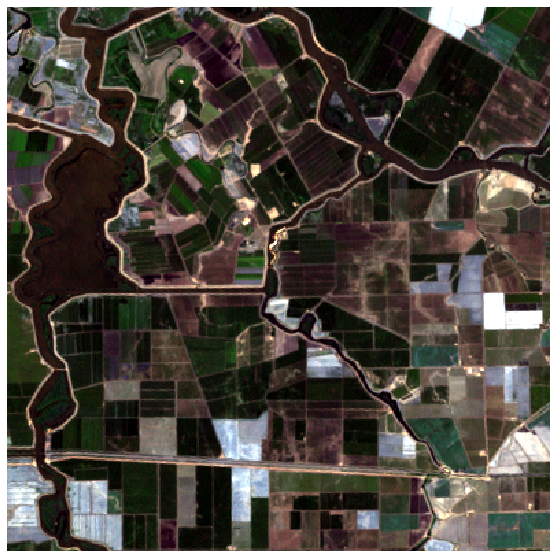

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(img_path_im)#[0:100,0:100])
plt.axis('off')
plt.savefig('3bands_init.tif')

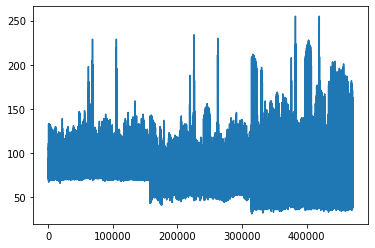

In [8]:
plt.plot(img_path.flatten())

# Load mask

In [9]:
# img_pil, img_np = get_image(img_path, imsize)
# img_mask_pil, img_mask_np = get_image(mask_path, imsize)

In [97]:
#Code for tomography image

#img_path.shape
# mask = np.ones(img_path.shape)
# mask[120:160] = 0
# img_mask_np = mask.copy()
# mask_path = img_mask_np

gap = np.zeros((img_path1.shape[0],64))
img_path = np.hstack((img_path1, gap, img_path2)) #, axis=2)

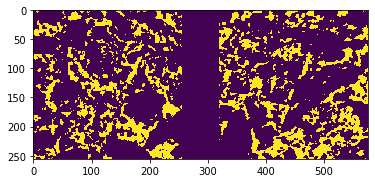

In [98]:
plt.imshow(img_path)

## CROP

In [11]:
# img_path = img_path[-150:,:150].reshape(150,150)
# plt.imshow(img_path)

In [12]:
# img_path = img_path[0:200,0:200]
# plt.imshow(img_path)

In [13]:
# mask_cr = mask_path[-150:,:150].reshape(150,150)
# img_path.shape

In [44]:
img_path.shape

(256, 576)

In [7]:
img_path=img_path_4 #.reshape(1,397,396)

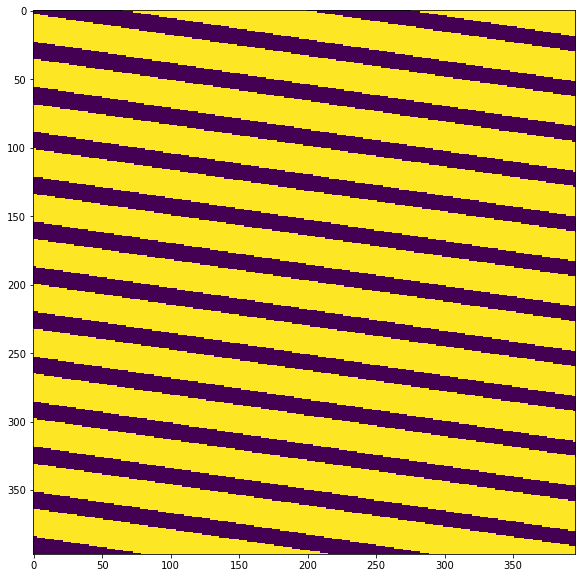

In [6]:
sh = list(img_path.shape)
n = 0
w= sh[1]+n
h= sh[2]+n
mask_path = mask_path[n:w,n:h]
plt.figure(figsize=(10,10))
plt.imshow(mask_path)
#plt.savefig("mask_3hid.png")

In [9]:
mask_path.shape

(397, 396)

In [10]:
count = np.unique(mask_path, return_counts=True)
print('Percentage of hidden pixels =', count[1][0]/count[1][1])

Percentage of hidden pixels = 0.5580816840269175


In [9]:
spoiled_img=np.zeros(img_path.shape)

for k in range(3):
    spoiled_img[k]=img_path[k]*mask_path

ValueError: could not broadcast input array from shape (397,396) into shape (396)

In [21]:
spoiled_img.shape

(3, 397, 396)

In [6]:
spoiled_img=_stretch_im(spoiled_img, 1)
spoiled_img = func(spoiled_img)   

plt.figure(figsize=(10,10))
plt.imshow(spoiled_img)
plt.axis('off')
plt.savefig("3bands_3hid.png")           

NameError: name 'spoiled_img' is not defined

## Custom image

In [7]:
# #four bands

img_list = []
for i in range(img_path.shape[0]):
    
    img_pil = crop_image((Image.fromarray(img_path[i])), d =32)
    img_np = pil_to_np(img_pil)
    img_list.append(img_np)  

In [8]:
# # four bands
img_np_raw = np.asarray(img_list)
img_np = img_np_raw.reshape(4,384,384)
img_mask_pil = crop_image((Image.fromarray(mask_path)), d =32)
img_mask_np = pil_to_np(img_mask_pil)

In [9]:
#one band
img_pil = crop_image(Image.fromarray(img_path.astype(np.uint8)), d =32)
img_np = pil_to_np(img_pil)


img_mask_pil = crop_image((Image.fromarray(mask_path)), d =32)
img_mask_np = pil_to_np(img_mask_pil)

# #CROPPED MASK
# # img_mask_pil = crop_image((Image.fromarray(mask_cr)), d =32)
# # img_mask_np = pil_to_np(img_mask_pil)

TypeError: Cannot handle this data type

In [12]:
# plt.figure()
# plt.imshow(img_mask_np1[0])

In [13]:
img_mask_np.shape


(1, 384, 384)

In [9]:
img_np.shape

(1, 384, 384)

In [23]:
# a=img_mask_np[0]*img_np[0]
# a[a>0.030]=0.030 

In [24]:
# plt.plot(a.flatten())

In [25]:
# plt.figure()
# plt.imshow(a[0:200,0:200])

### Center crop

In [26]:
# img_mask_pil = crop_image(img_mask_pil, dim_div_by)
# img_pil      = crop_image(img_pil,      dim_div_by)

# img_np      = pil_to_np(img_pil)
# img_mask_np = pil_to_np(img_mask_pil)

In [27]:
#img_corr = img_mask_np*img_np

In [28]:
# img_corr.shape

In [29]:
# plt.figure()
# plt.imshow(img_mask_np[0])

In [8]:
#for tomo
img_mask_np = np.hstack((np.ones(img_path1.shape),gap,np.ones(img_path1.shape)))


#CROPPED MASK
img_mask_pil = crop_image(Image.fromarray((img_mask_np * 255).astype(np.uint8)), d =32)
img_mask_np = pil_to_np(img_mask_pil)
#img_mask_np = np.expand_dims(img_mask_np,axis=2)

#img_mask_np = img_mask_np.reshape(256,576,1)

In [9]:
img_mask_np.shape

(1, 256, 576)

In [163]:
#for staelite

# un = np.unique(img_mask_np)

# img_mask_np[img_mask_np== un[0]] = 0.
# img_mask_np[img_mask_np== un[1]] = 1.

### Visualize

In [164]:
#img_mask_var = np_to_torch(img_mask_np).type(dtype)

# plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,11);

In [7]:
#for tomo
gap = np.zeros((img_path1.shape[0],64))
img_path = np.hstack((img_path1, gap, img_path2)) #, axis=2)

img_pil = crop_image(Image.fromarray((img_path * 255).astype(np.uint8)), d =32)
img_np = pil_to_np(img_pil)

#img_np = np.expand_dims(img_path,axis=2)

#img_np = img_np.reshape(256,576,1)

# Setup

In [10]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [11]:
img_np.shape[0] 

1

In [12]:
# #from deep_hs_prior paper

pad = 'reflection' #'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

method = 'noise'
input_depth = 1
LR = 0.01  
num_iter = 5000 #1250
param_noise = False
reg_noise_std = 0.1 # 0 0.01 0.03 0.05
figsize=5

show_every = 50
#save_every = 2000

net = skip(input_depth, img_np.shape[0], 
           num_channels_down = [128] * 5, 
           num_channels_up =   [128] * 5,
           num_channels_skip =    [128] * 5,  
           filter_size_up = 3, filter_size_down = 3, 
           upsample_mode='nearest', filter_skip_size=1,
           need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

'''
# UNet

reg_noise_std = 0.02
LR = 0.001

net = UNet(num_input_channels=input_depth, num_output_channels=img_np.shape[0], 
           feature_scale=8, more_layers=1, 
           concat_x=False, upsample_mode='deconv', 
           pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
'''


'''
#ResNet

reg_noise_std = 0.02
LR = 0.001
net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')

LR = 0.001
param_noise = False
'''        

net = net.type(dtype)
net_input = get_noise(input_depth, method, img_np.shape[1:]).type(dtype)

In [13]:
# if 'vase.png' in img_path:
#     INPUT = 'meshgrid'
#     input_depth = 2
#     LR = 0.01 
#     num_iter = 5001
#     param_noise = False
#     show_every = 50
#     figsize = 5
#     reg_noise_std = 0.03
    
#     net = skip(input_depth, img_np.shape[0], 
#                num_channels_down = [128] * 5,
#                num_channels_up   = [128] * 5,
#                num_channels_skip = [0] * 5,  
#                upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
#                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
# elif ('kate.png' in img_path) or ('peppers.png' in img_path):
#     # Same params and net as in super-resolution and denoising
#     INPUT = 'noise'
#     input_depth = 32
#     LR = 0.01 
#     num_iter = 10001
#     param_noise = False
#     show_every = 50
#     figsize = 5
#     reg_noise_std = 0.03
    
#     net = skip(input_depth, img_np.shape[0], 
#                num_channels_down = [128] * 5,
#                num_channels_up =   [128] * 5,
#                num_channels_skip =    [128] * 5,  
#                filter_size_up = 3, filter_size_down = 3, 
#                upsample_mode='nearest', filter_skip_size=1,
#                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
# elif 'library.png' in img_path:
    
#     INPUT = 'noise'
#     input_depth = 1
    
#     num_iter = 3001
#     show_every = 50
#     figsize = 8
#     reg_noise_std = 0.00
#     param_noise = True
    
# else:
#     INPUT = 'noise'
#     input_depth = 4
#     LR = 0.01 
#     num_iter = 6001
#     param_noise = False
#     show_every = 50
#     figsize = 5
#     reg_noise_std = 0.03
    
    
#     if 'skip' in NET_TYPE:
        
#         depth = int(NET_TYPE[-1])
#         net = skip(input_depth, img_np.shape[0], 
#                    num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
#                    num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
#                    num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
#                    filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,  
#                    upsample_mode='nearest', 
#                    need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
        
#         LR = 0.01 
        
#     elif NET_TYPE == 'UNET':
        
#         net = UNet(num_input_channels=input_depth, num_output_channels=3, 
#                    feature_scale=8, more_layers=1, 
#                    concat_x=False, upsample_mode='deconv', 
#                    pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
#         LR = 0.001
#         param_noise = False
        
#     elif NET_TYPE == 'ResNet':
        
#         net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
        
#         LR = 0.001
#         param_noise = False
        
#     else:
#         assert False
# # else:
# #     assert False

# net = net.type(dtype)
# net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [14]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 2962689


In [15]:
img_mask_np.shape

(1, 256, 576)

In [16]:
img_var.size()

torch.Size([1, 1, 256, 576])

In [17]:
mask_var.size()

torch.Size([1, 1, 256, 576])

# Main loop

Starting optimization with ADAM


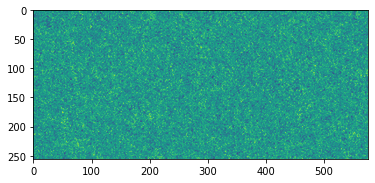

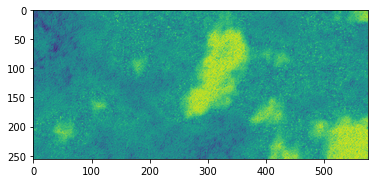

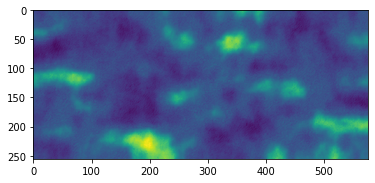

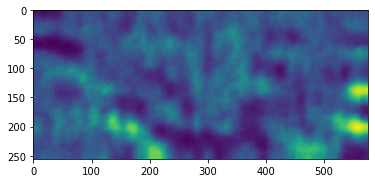

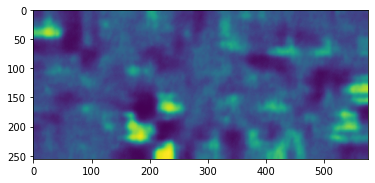

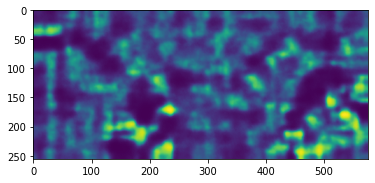

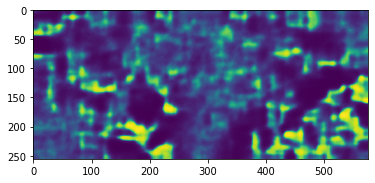

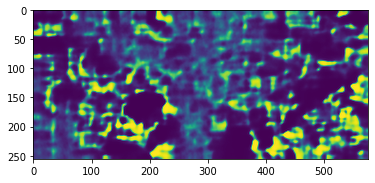

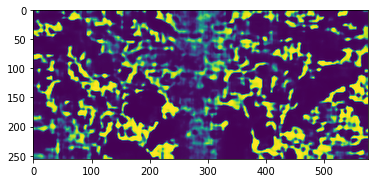

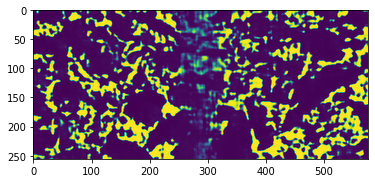

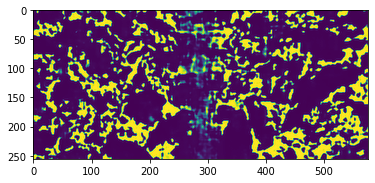

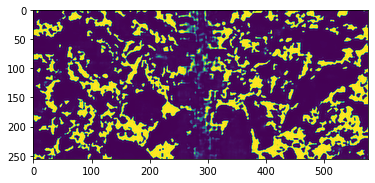

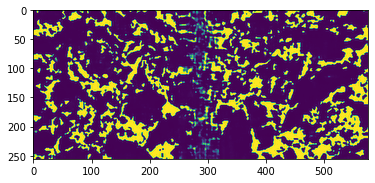

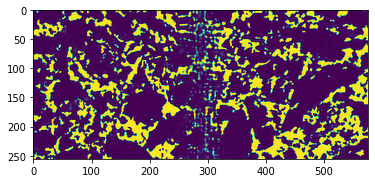

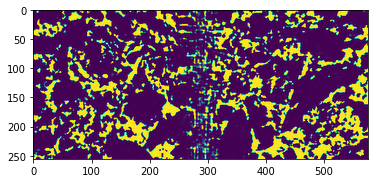

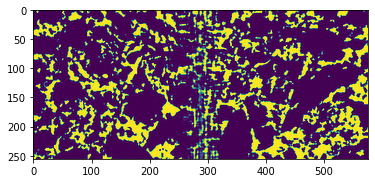

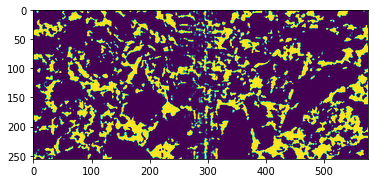

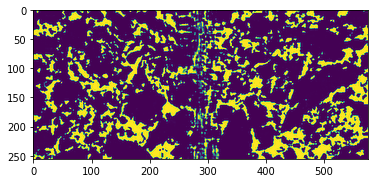

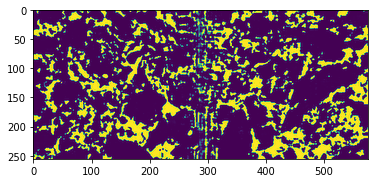

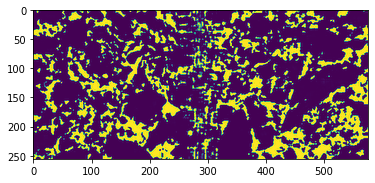

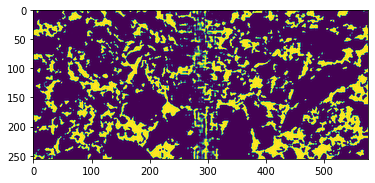

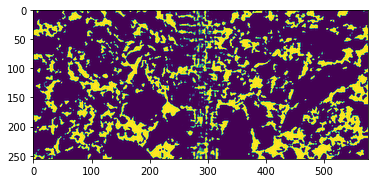

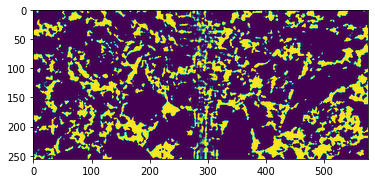

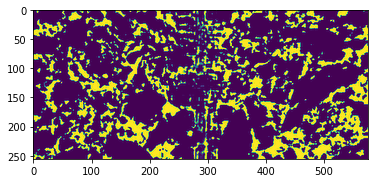

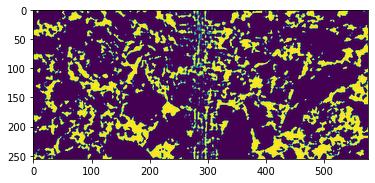

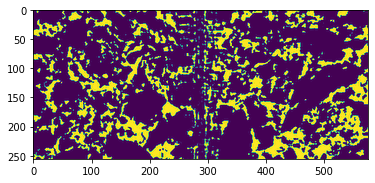

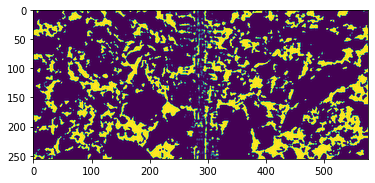

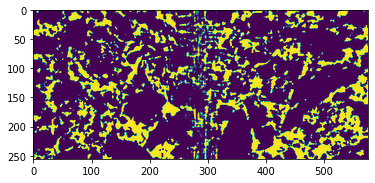

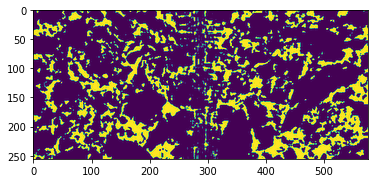

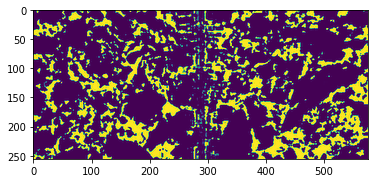

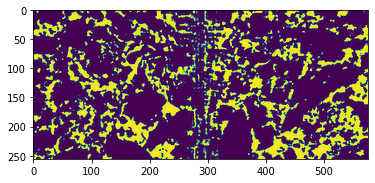

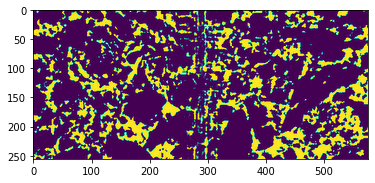

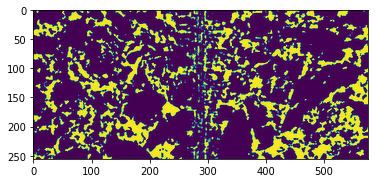

In [ ]:
i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [21]:
#four bands
#images_np = np.asarray([np.concatenate([x, x, x, x], axis=0) for x in img_np])

In [58]:
plt.plot(loss[0:110])

NameError: name 'loss' is not defined

In [59]:
plt.plot(RMSE_test)

NameError: name 'RMSE_test' is not defined

In [60]:
min(RMSE_test)

NameError: name 'RMSE_test' is not defined

In [61]:
with open('RMSE_test_skip6.txt', 'w') as f:
    for item in RMSE_test:
        f.write("%s\n" % item)
        
with open('RMSE_train_skip6.txt', 'w') as f:
    for item in loss:
        f.write("%s\n" % item)

NameError: name 'RMSE_test' is not defined

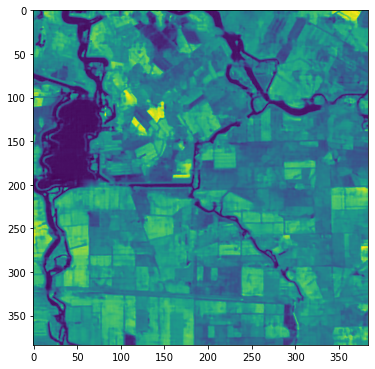

In [22]:
out_np = torch_to_np(net(net_input))
plot_image_grid([out_np], factor=5);

In [44]:
plt.figure(figsize = (12,12))
plt.imshow(out, cmap ='gray');
#plt.savefig('band_1_recon.jpeg', bbox_inches = 0, pad_inches = 0)

NameError: name 'out' is not defined

<Figure size 864x864 with 0 Axes>

In [23]:
#RMSE_init = math.sqrt(mean_squared_error(img_np[0], img_corr[0]))
RMSE_out = math.sqrt(mean_squared_error(img_np.flatten(), out_np.flatten()))
print('Result_RMSE =', RMSE_out)

Result_RMSE = 0.05212049896688791


In [24]:
r2 = r2_score(img_np.flatten(), out_np.flatten())

In [25]:
r2

0.832063645128879

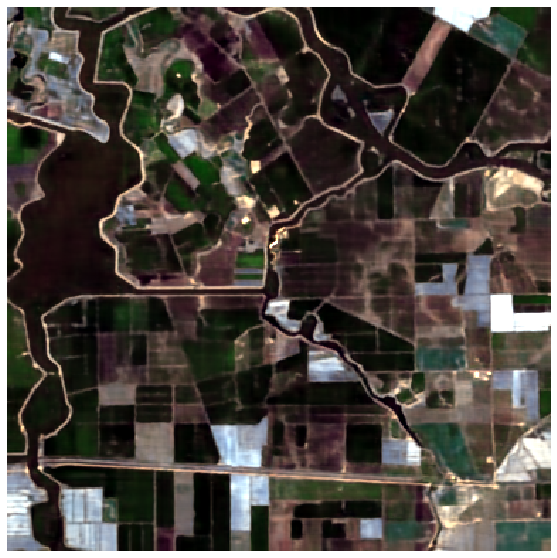

In [47]:
out_np_im=_stretch_im(out_np, 1)
out_np_im = func(out_np_im)   

plt.figure(figsize=(10,10))
plt.imshow(out_np_im
          )
plt.axis('off')

plt.savefig("3bands_3hid_res.png")

## Comparison 

In [ ]:
out_np[0]

In [ ]:
out_np = torch_to_np(net(net_input))

In [ ]:
mask_tif = Image.open('./gap_mask')
mask_path = np.array(mask_tif)
img_mask_pil = crop_image((Image.fromarray(mask_path)), d =32)
img_mask_np = pil_to_np(img_mask_pil)
un = np.unique(img_mask_np)
un[1]

In [ ]:
img_mask_np[img_mask_np== un[0]] = 1.
img_mask_np[img_mask_np== un[1]] = 0.

In [ ]:
mask_out = out_np*img_mask_np

In [ ]:
plt.figure(figsize = (12,12))
plt.imshow(mask_out[0], cmap ='gray');

In [ ]:
sh = img_np.shape
mask_out_fl = mask_out.flatten()
img_np_fl = img_np.flatten()

idx = [mask_out_fl == 0]
mask_out_fl[idx] = img_np_fl[idx]
img_np_out = np.reshape(mask_out_fl,(sh))

In [ ]:
plt.figure(figsize = (12,12))
plt.imshow(img_np_out[0], cmap ='gray');

In [ ]:
RMSE_out = math.sqrt(mean_squared_error(img_np[0], img_np_out[0]))
print('Result_RMSE =', RMSE_out)

In [ ]:
r2 = r2_score(img_np[0], img_np_out[0])
r2